<a href="https://colab.research.google.com/github/kbrezinski/CS224W-GraphML/blob/main/notebooks/node2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import torch
print(torch.__version__)

from platform import python_version
print(python_version())

1.11.0+cu113
3.7.13


In [6]:
!pip install torch-scatter torch-sparse \
 torch-cluster torch-spline-conv torch-geometric \
-f https://data.pyg.org/whl/torch-1.11.0+cu113.html -q
#!pip install ogb

In [7]:
import os
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import Node2Vec
from torch_geometric.loader import DataLoader

In [8]:
# setting up model
dataset = 'Cora'
path = os.path.join(os.getcwd(), '..', 'data', dataset)
dataset = Planetoid(path, dataset)
data = dataset[0]

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Node2Vec(data.edge_index, embedding_dim=128, walk_length=20,
                  context_size=10, walks_per_node=10,
                  num_negative_samples=1, p=1, q=1, sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=2)
#loader = DataLoader(data, batch_size=128, shuffle=True, num_workers=2)
optimizer = torch.optim.SparseAdam(model.parameters(), lr=1e-2)

Epoch: 00, Loss: 0.9605, Acc: 0.6300
Epoch: 25, Loss: 0.8366, Acc: 0.7190
Epoch: 50, Loss: 0.8261, Acc: 0.7120
Epoch: 75, Loss: 0.8248, Acc: 0.7090


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


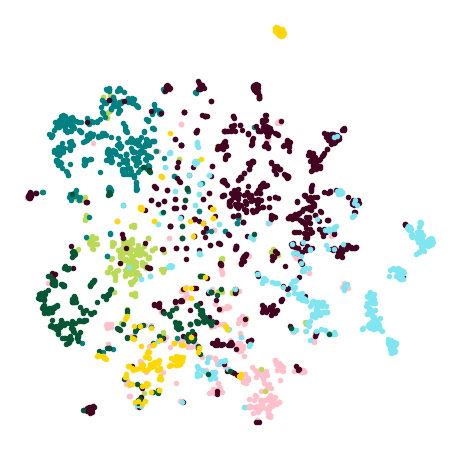

In [11]:
def train(model, loader):
  model.train()
  total_loss = 0
  for pos_rw, neg_rw in loader:
      optimizer.zero_grad()
      loss = model.loss(pos_rw.to(device), neg_rw.to(device))
      loss.backward()
      optimizer.step()
      total_loss += loss.item()
  return total_loss / len(loader)

@torch.no_grad()
def test(model, loader):
    model.eval()
    z = model()
    acc = model.test(z[data.train_mask], data.y[data.train_mask],
                      z[data.test_mask], data.y[data.test_mask],
                      max_iter=150)
    return acc

for epoch in range(100):
  loss = train(model, loader)
  acc = test(model, loader)
  if not epoch % 25:
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Acc: {acc:.4f}')


@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model(torch.arange(data.num_nodes, device=device))
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = data.y.cpu().numpy()

    plt.figure(figsize=(8, 8))
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()

colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535',
    '#ffd700'
]
plot_points(colors)